In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train.reshape(X_train.shape[0],1,28*28)
X_train = X_train.astype(np.float64)
X_train /= 255
X_train = X_train.squeeze()

In [4]:
X_train.shape

(60000, 784)

In [5]:
X_test = X_test.reshape(X_test.shape[0],1,28*28)
X_test = X_test.astype(np.float64).squeeze()
X_test /= 255

In [6]:
class Layer:
  def __init__(self):
      self.input = None
      self.output = None

  def forward_propogation(self,X,y):
    pass

  def backward_propogation(self,X,y):
    pass

In [7]:
class Linear(Layer):
  def __init__(self, input,output,range = None):
      super().__init__()
      if range == None:
        self.weights = np.zeros((output, input))
        self.bias = np.zeros((output))
      else:
        self.weights = (np.random.rand(output,input) * 2 * range) - range
        self.bias = np.random.rand(output) - 0.5

  def forward_propogation(self, X):
      self.X = X
      self.output = ((self.weights @ self.X.T).T + self.bias)
      return self.output

  def backward_propogation(self, error_output, alpha):
    error = error_output @ self.weights
    self.w_error = error_output.T @ self.X
    self.weights = self.weights - (alpha*self.w_error)
    self.bias = self.bias-(alpha*error_output)
    return error

In [8]:
class sigmoid(Layer):
  def __init__(self):
      super().__init__()

  def forward_propogation(self,input):
    self.input = 1.0/(1.0+np.exp(-input))
    return self.input
    
  def backward_propogation(self,error_output,alpha):
    # print('input'+str(self.input.T))
    # print('eeror output'+str(error_output))
    return self.input * (1 - self.input) * error_output

In [9]:
class tanh(Layer):
  def __init__(self):
      super().__init__()
      
  def forward_propogation(self,input):
    self.input = np.tanh(input)
    return self.input

  def backward_propogation(self,error_output,alpha):
    return (1 - self.input**2) * error_output

In [10]:
class softmax(Layer):
  def __init__(self):
      super().__init__()

  def forward_propogation(self, input):
      exps = np.exp(input - input.max())
      return exps / np.sum(np.exp(exps), axis=0, keepdims=True)

  def backward_propogation(self, error_output, alpha):
    #   grad = 1/(1+np.exp(-self.input))
    #   return grad * (1-grad) * error_output
    # This derivative is already computed with crossEntropyLoss.
    return error_output

In [11]:
class crossEntropyLoss(Layer):
  def __init__(self):
      super().__init__()

  def forward_propogation(self,y,y_pred):
    return -y * np.log(y_pred)

  def backward_propogation(self,y,y_pred):
    return y_pred - y

In [30]:
class Sequential(Layer):
  def __init__(self):
      super().__init__()
      self.layers = []
      self.error = None
      self.err = []

  def add(self,layer):
      self.layers.append(layer)

  def set_error(self,error):
    self.error = error

  def fit(self, X, y,epochs = 10,alpha = 0.01):
      self.alpha = alpha
      n = X.shape[0]
      count = 0
      toterror = list()
      for i in range(epochs):
          total_error = 0
    
          for j in range(n):
              y_pred = X[j]
              if (y_pred.ndim == 1):
                y_pred = y_pred[None, :]
              # print(y_pred.shape)
              #Forward Propogation
              for k in self.layers:
                  y_pred = k.forward_propogation(y_pred)
              #Error for current 
              # NOTE: Compute the mean over the batch (not implemented yet) and then sum them up.
              total_error += np.sum(np.mean(self.error.forward_propogation(y[j],y_pred), axis=0))
              output_error = np.array(self.error.backward_propogation(y[j],y_pred))
              
              #Backward Propogation
              for k in reversed(self.layers):
                  output_error = k.backward_propogation(output_error,alpha)
          count += 1
          
          total_error = total_error/n
          self.err.append(round(total_error,6))
          #Early Stopping if accuracy doesn't change for 5 steps
          if count>5 and all(a == self.err[-1:] for a in self.err[-5:]):
            break
          print('epoch %d-------------------> error: %f'%(i+1,total_error))


  def predict(self,X,probability = False):
    n = X.shape[0]
    y_pred_matrix = []
    y_pred = []
    for i in range(n):
      out = X[i]

      for j in self.layers:
          out = j.forward_propogation(out)
      y_pred_matrix.append(out)

    if probability:
      return y_pred_matrix
    # print(y_pred_matrix[0])
    for i in y_pred_matrix:
      i[i>0.5] = 1
      i[i<0.5] = 0
    print(y_pred_matrix[0])     
    # for res in y_pred_matrix:
    #   y_pred.append(np.argmax(res))
    return np.array(y_pred_matrix)

  def plot(self):
    plt.figure(figsize=(15,5))
    plt.plot(self.err, '--r')
    plt.title(f"Loss vs Epochs :: Learning Rate : {self.alpha}", fontsize=18)
    plt.xlabel("Epochs",fontsize=18)
    plt.ylabel("loss", fontsize=18)
    plt.show()


In [13]:
samples = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
targets = np.array([[0], [1], [1], [0]])


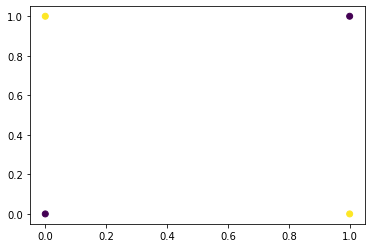

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[:, 0], samples[:, 1], c=targets)

In [15]:
model1 = Sequential()
model1.add(Linear(2,2,2))
model1.add(sigmoid())
model1.add(Linear(2,1,2))
model1.add(sigmoid())
model1.set_error(crossEntropyLoss())


In [16]:
model1.fit(samples,targets,10,0.01)

epoch 1-------------------> error: 0.539421
epoch 2-------------------> error: 0.538824
epoch 3-------------------> error: 0.538230
epoch 4-------------------> error: 0.537637
epoch 5-------------------> error: 0.537046
epoch 6-------------------> error: 0.536457
epoch 7-------------------> error: 0.535870
epoch 8-------------------> error: 0.535284
epoch 9-------------------> error: 0.534700
epoch 10-------------------> error: 0.534118


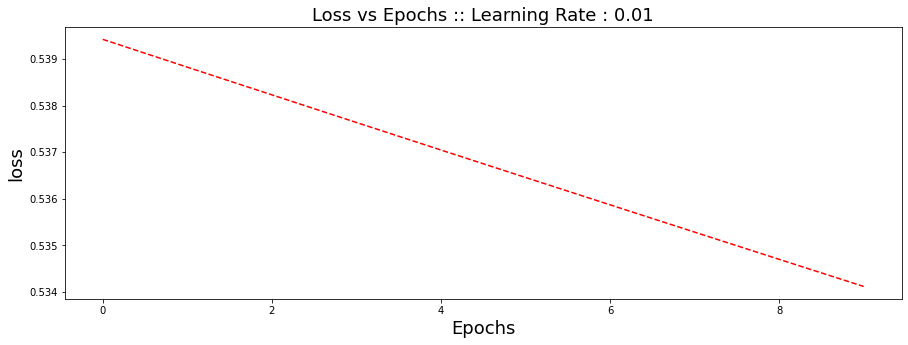

In [17]:
model1.plot()

In [18]:
with open('xor_solved.pkl', 'wb') as outp:
    pickle.dump(model1, outp, pickle.HIGHEST_PROTOCOL)

In [20]:
model2 = Sequential()
model2.add(Linear(2,2,2))
model2.add(tanh())
model2.add(Linear(2,1,2))
model2.add(sigmoid())
model2.set_error(crossEntropyLoss())
model2.fit(samples,targets,10,0.01)

epoch 1-------------------> error: 0.231183
epoch 2-------------------> error: 0.231519
epoch 3-------------------> error: 0.231853
epoch 4-------------------> error: 0.232187
epoch 5-------------------> error: 0.232521
epoch 6-------------------> error: 0.232853
epoch 7-------------------> error: 0.233185
epoch 8-------------------> error: 0.233516
epoch 9-------------------> error: 0.233846
epoch 10-------------------> error: 0.234176


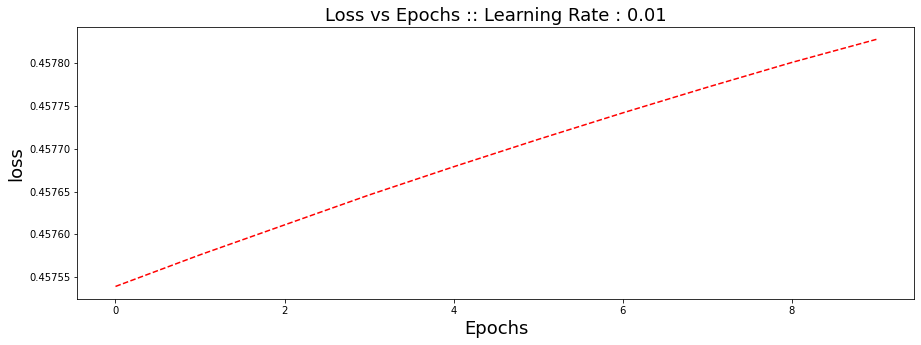

In [20]:
model2.plot()

In [21]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [22]:
y_train =  get_one_hot(y_train.astype(int), 10)
y_test = get_one_hot(y_test.astype(int), 10)

In [ ]:

model_1 = Sequential()
model_1.add(Linear(28*28,64))
model_1.add(tanh())
model_1.add(Linear(64,10))
model_1.add(sigmoid())
model_1.set_error(crossEntropyLoss())
model_1.fit(X_train,y_train,10,0.001)

epoch 1-------------------> error: 1.470950
epoch 2-------------------> error: 1.983296
epoch 3-------------------> error: 2.136244
epoch 4-------------------> error: 2.207836
epoch 5-------------------> error: 2.246210
epoch 6-------------------> error: 2.268104
epoch 7-------------------> error: 2.281024
epoch 8-------------------> error: 2.288801


In [29]:
predicted = model_1.predict(X_test)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [26]:
print(f'Accuracy of model 1 : {round(np.mean(predicted == y_test)*100,2)} %')

Accuracy of model 1 : 90.0 %


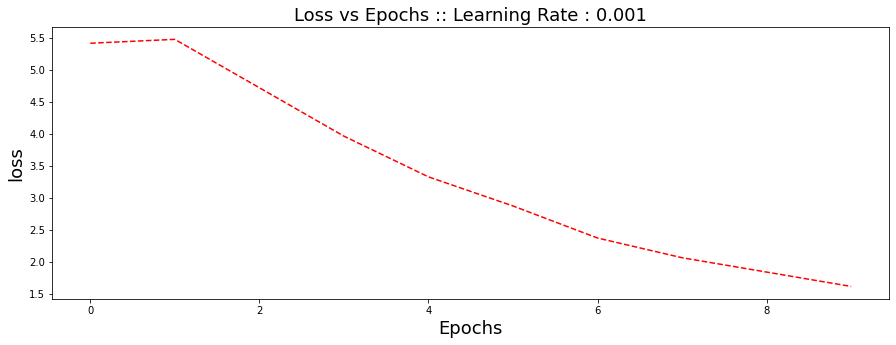

In [81]:
model_1.plot()

In [82]:
model_2 = Sequential()
model_2.add(Linear(28*28,100,10))
model_2.add(tanh())
model_2.add(Linear(100,10,10))
model_2.add(sigmoid())
model_2.set_error(crossEntropyLoss())
model_2.fit(X_train,y_train,10,0.01)

epoch 1-------------------> error: 47.188610
epoch 2-------------------> error: 74.531323
epoch 3-------------------> error: 84.111409
epoch 4-------------------> error: 88.908759
epoch 5-------------------> error: 92.029252
epoch 6-------------------> error: 94.082333
epoch 7-------------------> error: 95.567963
epoch 8-------------------> error: 96.877056
epoch 9-------------------> error: 97.713883
epoch 10-------------------> error: 98.347873


In [ ]:
predicted = model_2.predict(X_test)
print(f'Accuracy of model 2 : {round(np.mean(predicted == y_test)*100,2)} %')

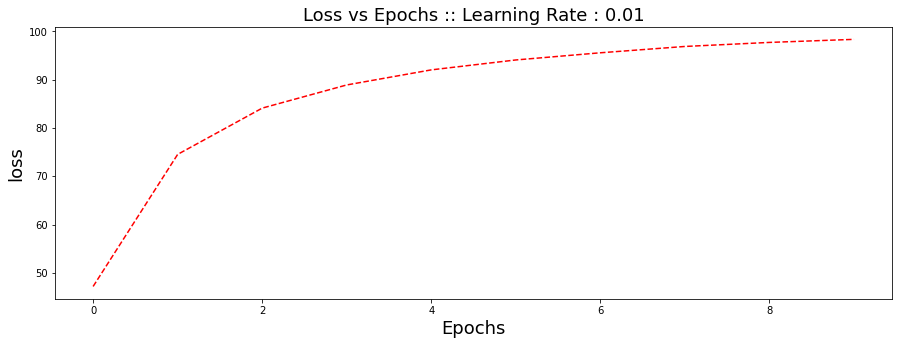

In [84]:
model_2.plot()

In [85]:
model_3 = Sequential()
model_3.add(Linear(28*28,100,1))
model_3.add(tanh())
model_3.add(Linear(100,10,1))
model_3.add(sigmoid())
model_3.set_error(crossEntropyLoss())
model_3.fit(X_train,y_train,10,1)

epoch 1-------------------> error: 14.414839
epoch 2-------------------> error: 14.530649
epoch 3-------------------> error: 12.491681
epoch 4-------------------> error: 10.793119
epoch 5-------------------> error: 11.157114
epoch 6-------------------> error: 10.648070
epoch 7-------------------> error: 10.496581
epoch 8-------------------> error: 11.047631
epoch 9-------------------> error: 11.385967
epoch 10-------------------> error: 12.430111


In [86]:
predicted = model_3.predict(X_test)
print(f'Accuracy of model 3 : {round(np.mean(predicted == y_test)*100,2)} %')

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Accuracy of model 3 : 84.86 %


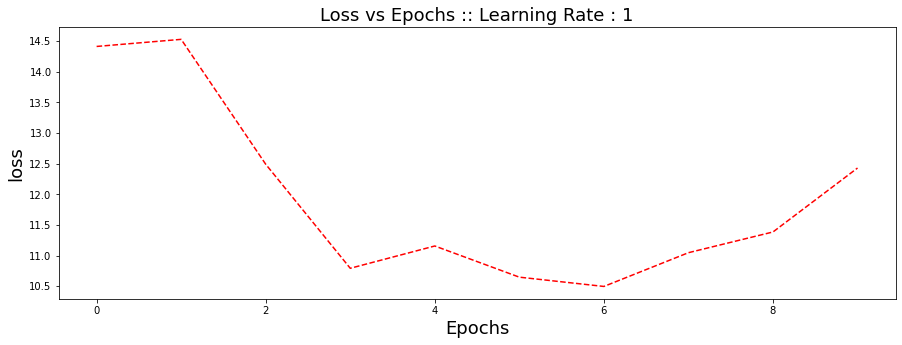

In [87]:
model_3.plot()

In [88]:
model_4 = Sequential()
model_4.add(Linear(28*28,100,1))
model_4.add(tanh())
model_4.add(Linear(100,10,1))
model_4.add(sigmoid())
model_4.set_error(crossEntropyLoss())
model_4.fit(X_train,y_train,10,0.001)

epoch 1-------------------> error: 8.701419
epoch 2-------------------> error: 9.312245
epoch 3-------------------> error: 8.675773
epoch 4-------------------> error: 8.084560
epoch 5-------------------> error: 7.655508
epoch 6-------------------> error: 7.339316
epoch 7-------------------> error: 7.139511
epoch 8-------------------> error: 7.006572
epoch 9-------------------> error: 6.913537
epoch 10-------------------> error: 6.830590


In [89]:
predicted = model_4.predict(X_test)
print(f'Accuracy of model 4 : {round(np.mean(predicted == y_test)*100,2)} %')

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Accuracy of model 4 : 86.09 %


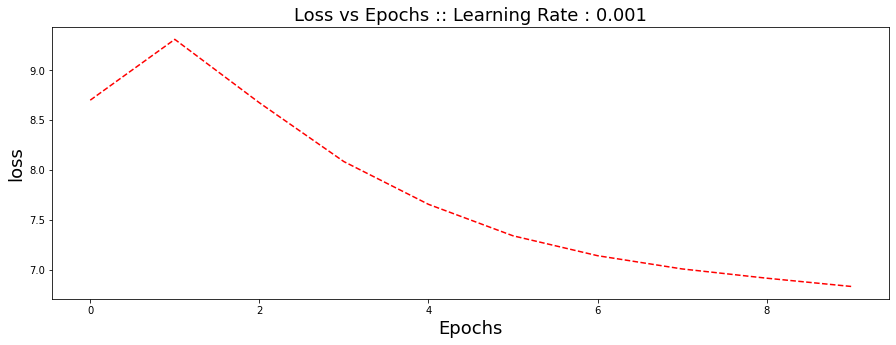

In [90]:
model_4.plot()